In [189]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.visualization import plot_distribution, plot_histogram, plot_bloch_multivector
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from utils import get_image_path
from scipy.optimize import minimize_scalar, OptimizeResult, minimize

![diagram](./assets/buckshot-roulette-diagram.png)

In [58]:
player_strategy = lambda bullets, fakes: "himself" if(bullets == fakes or fakes > bullets) else "shoot"
dealer_strategy = lambda bullets, fakes:  "himself" if np.random.randint(2) else "shoot"

In [81]:
def gun(bullets, fakes) -> bool:
    v = bullets + fakes
    r = np.random.randint(1, v+1)
    return r <= bullets
    

def play(strategies:dict, players:list, total_bullets:int, total_fakes:int, debug:bool=False) -> pd.DataFrame:
    lives = {
        "player":0,
        "dealer":0
    }

    actual_player = players[0]
    oponent = players[1]
    rounds = 0
    while(total_bullets):
        player = strategies[actual_player]
        action = player(total_bullets, total_fakes)
        shot = gun(total_bullets, total_fakes)

        if(debug):
            print(f"playing: {actual_player}")
            print(f"oponent: {oponent}")
            print(f"action: {action}")
            print(f"shot: {shot}")
        

        if(action == "shoot" and shot):
            lives[oponent] -=1
            total_bullets -=1
            actual_player = players[0]
            oponent = players[1]

        elif(action == "shoot" and not shot):
            total_fakes -=1
            actual_player,oponent = oponent,actual_player

        elif(action == "himself" and shot):
            lives[actual_player] -=1
            total_bullets -=1
            actual_player = players[0]
            oponent = players[1]

        else:
            total_fakes -=1            

        if(debug):
            print(lives, end="\n\n")

        rounds += 1

    if(lives['player'] > lives['dealer']):
        return 'player', rounds
    elif(lives['dealer'] > lives['player']):
        return 'dealer', rounds
    else:
        return 'draw', rounds


In [82]:
play({"player":player_strategy, "dealer":dealer_strategy}, ("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)

playing: player
oponent: dealer
action: himself
shot: False
{'player': 0, 'dealer': 0}

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



('dealer', 2)

In [94]:
def get_experiment_results(n:int, players_strategies:dict, players:list, total_bullets:int, total_fakes:int):
    df = pd.DataFrame(columns=("total_player", "total_dealer"))
    n_rounds = pd.Series()

    j = 1000
    for i in range(n):
        results = {"player":0, "dealer":0}
        for _ in range(j):
            result, rounds = play(players_strategies, players, total_bullets, total_fakes)
            results[result]+=1
            n_rounds.loc[j*i + j] = rounds
        df.loc[i] = {"total_player":results['player'], "total_dealer":results['dealer']}
    return df, n_rounds

1    337
3    334
2    329
Name: count, dtype: int64


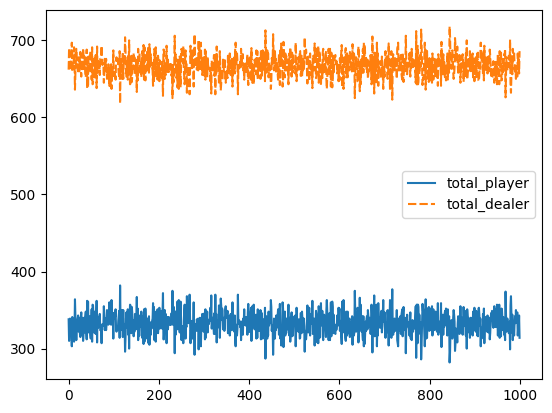

In [125]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

3    351
2    334
1    315
Name: count, dtype: int64


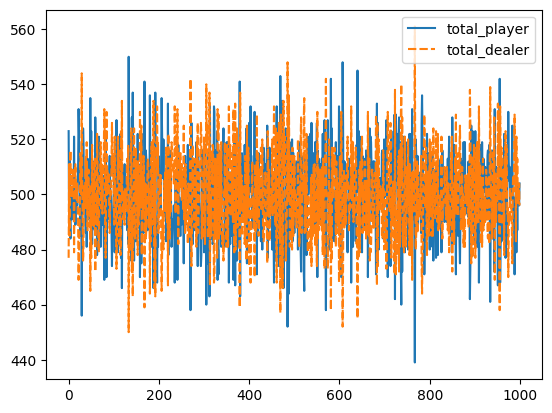

In [126]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":dealer_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

2    349
3    330
1    321
Name: count, dtype: int64


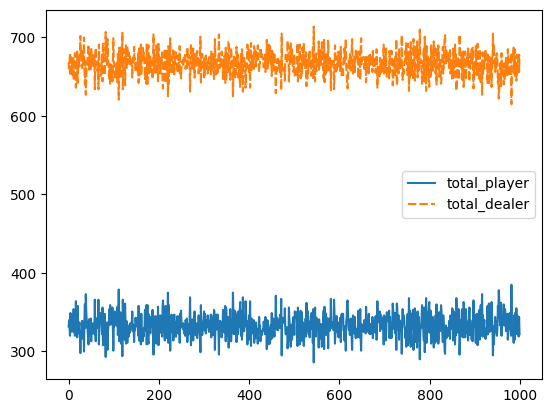

In [127]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_strategy, "dealer":player_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [75]:
def player_start_himself_strategy(bullets, fakes):
    if(bullets == 1 and fakes == 2):
        return 'himself'

    elif(bullets == fakes):
        return 'shoot' if np.random.randint(2) else "himself"

    return 'shoot'

2    366
1    331
3    303
Name: count, dtype: int64


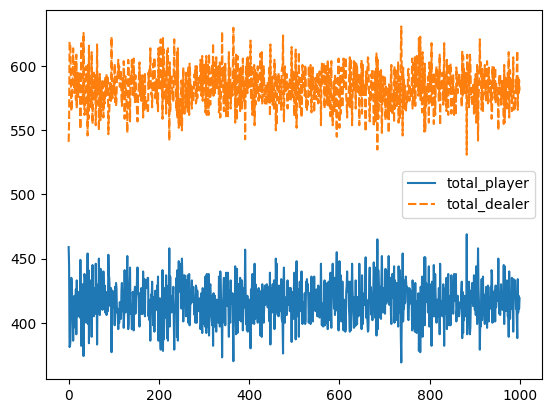

In [128]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_start_himself_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [79]:
def player_optimal_strategy(bullets, fakes):
    if(bullets == 1 and fakes == 2):
        return 'shoot'

    elif(bullets == fakes):
        return 'shoot' if np.random.randint(2) else "himself"

    return 'shoot'

2    1056
1    1001
3     943
Name: count, dtype: int64


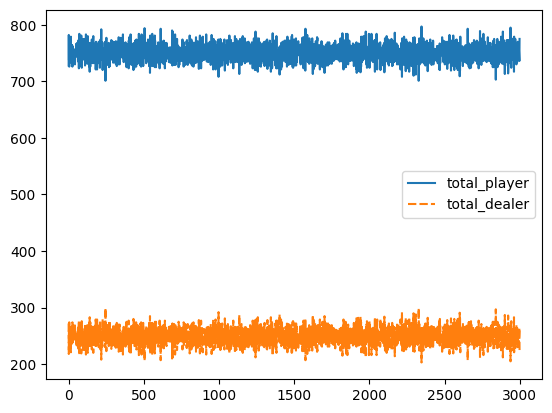

In [130]:
df,rounds = get_experiment_results(n=3000, players_strategies={"player":player_optimal_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [135]:
df,rounds = play({"player":player_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the first strategy, there're some possible ways to finish the game

# player shoot himself (first round)
# dealer shoot himself (second round)
# dealer shoot the player (second round)
# player shoot (third round)

# so the player loses most part of the time

playing: player
oponent: dealer
action: himself
shot: False
{'player': 0, 'dealer': 0}

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



2

In [148]:
df,rounds = play({"player":player_start_himself_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the second strategy, there're some possible ways to finish the game

# player shoot himself (first round)
# player shoot himself (second round)
# player shoot the dealer (second round)
# dealer shoot the player (third round)
# dealer shoot himself (third round)

# so the player loses most part of the time

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



1

In [155]:
df,rounds = play({"player":player_optimal_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the third strategy, there're some possible ways to finish the game

# player shoot the dealer (first round)
# dealer shoot himself (second round)
# dealer shoot the player (second round)
# dealer shoot himself (third round)
# dealer shoot the player (third round)
# player shoot the dealer(third round)

# so the dealer loses most part of the time
# as in the first play the player chooses to shoot the dealer, he has more chances to live, once he's removed one of the dying chances

playing: player
oponent: dealer
action: shoot
shot: True
{'player': 0, 'dealer': -1}



1

---

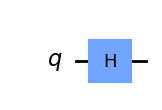

In [2]:
player = QuantumCircuit(1, name="Player")
player.h(0)
player.draw('mpl', style="clifford")

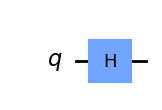

In [3]:
dealer = QuantumCircuit(1, name="Dealer")
dealer.h(0)
player.draw('mpl', style="clifford")

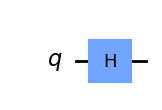

In [4]:
gun = QuantumCircuit(1, name="shoot")
gun.h(0)
gun.draw('mpl', style='clifford')

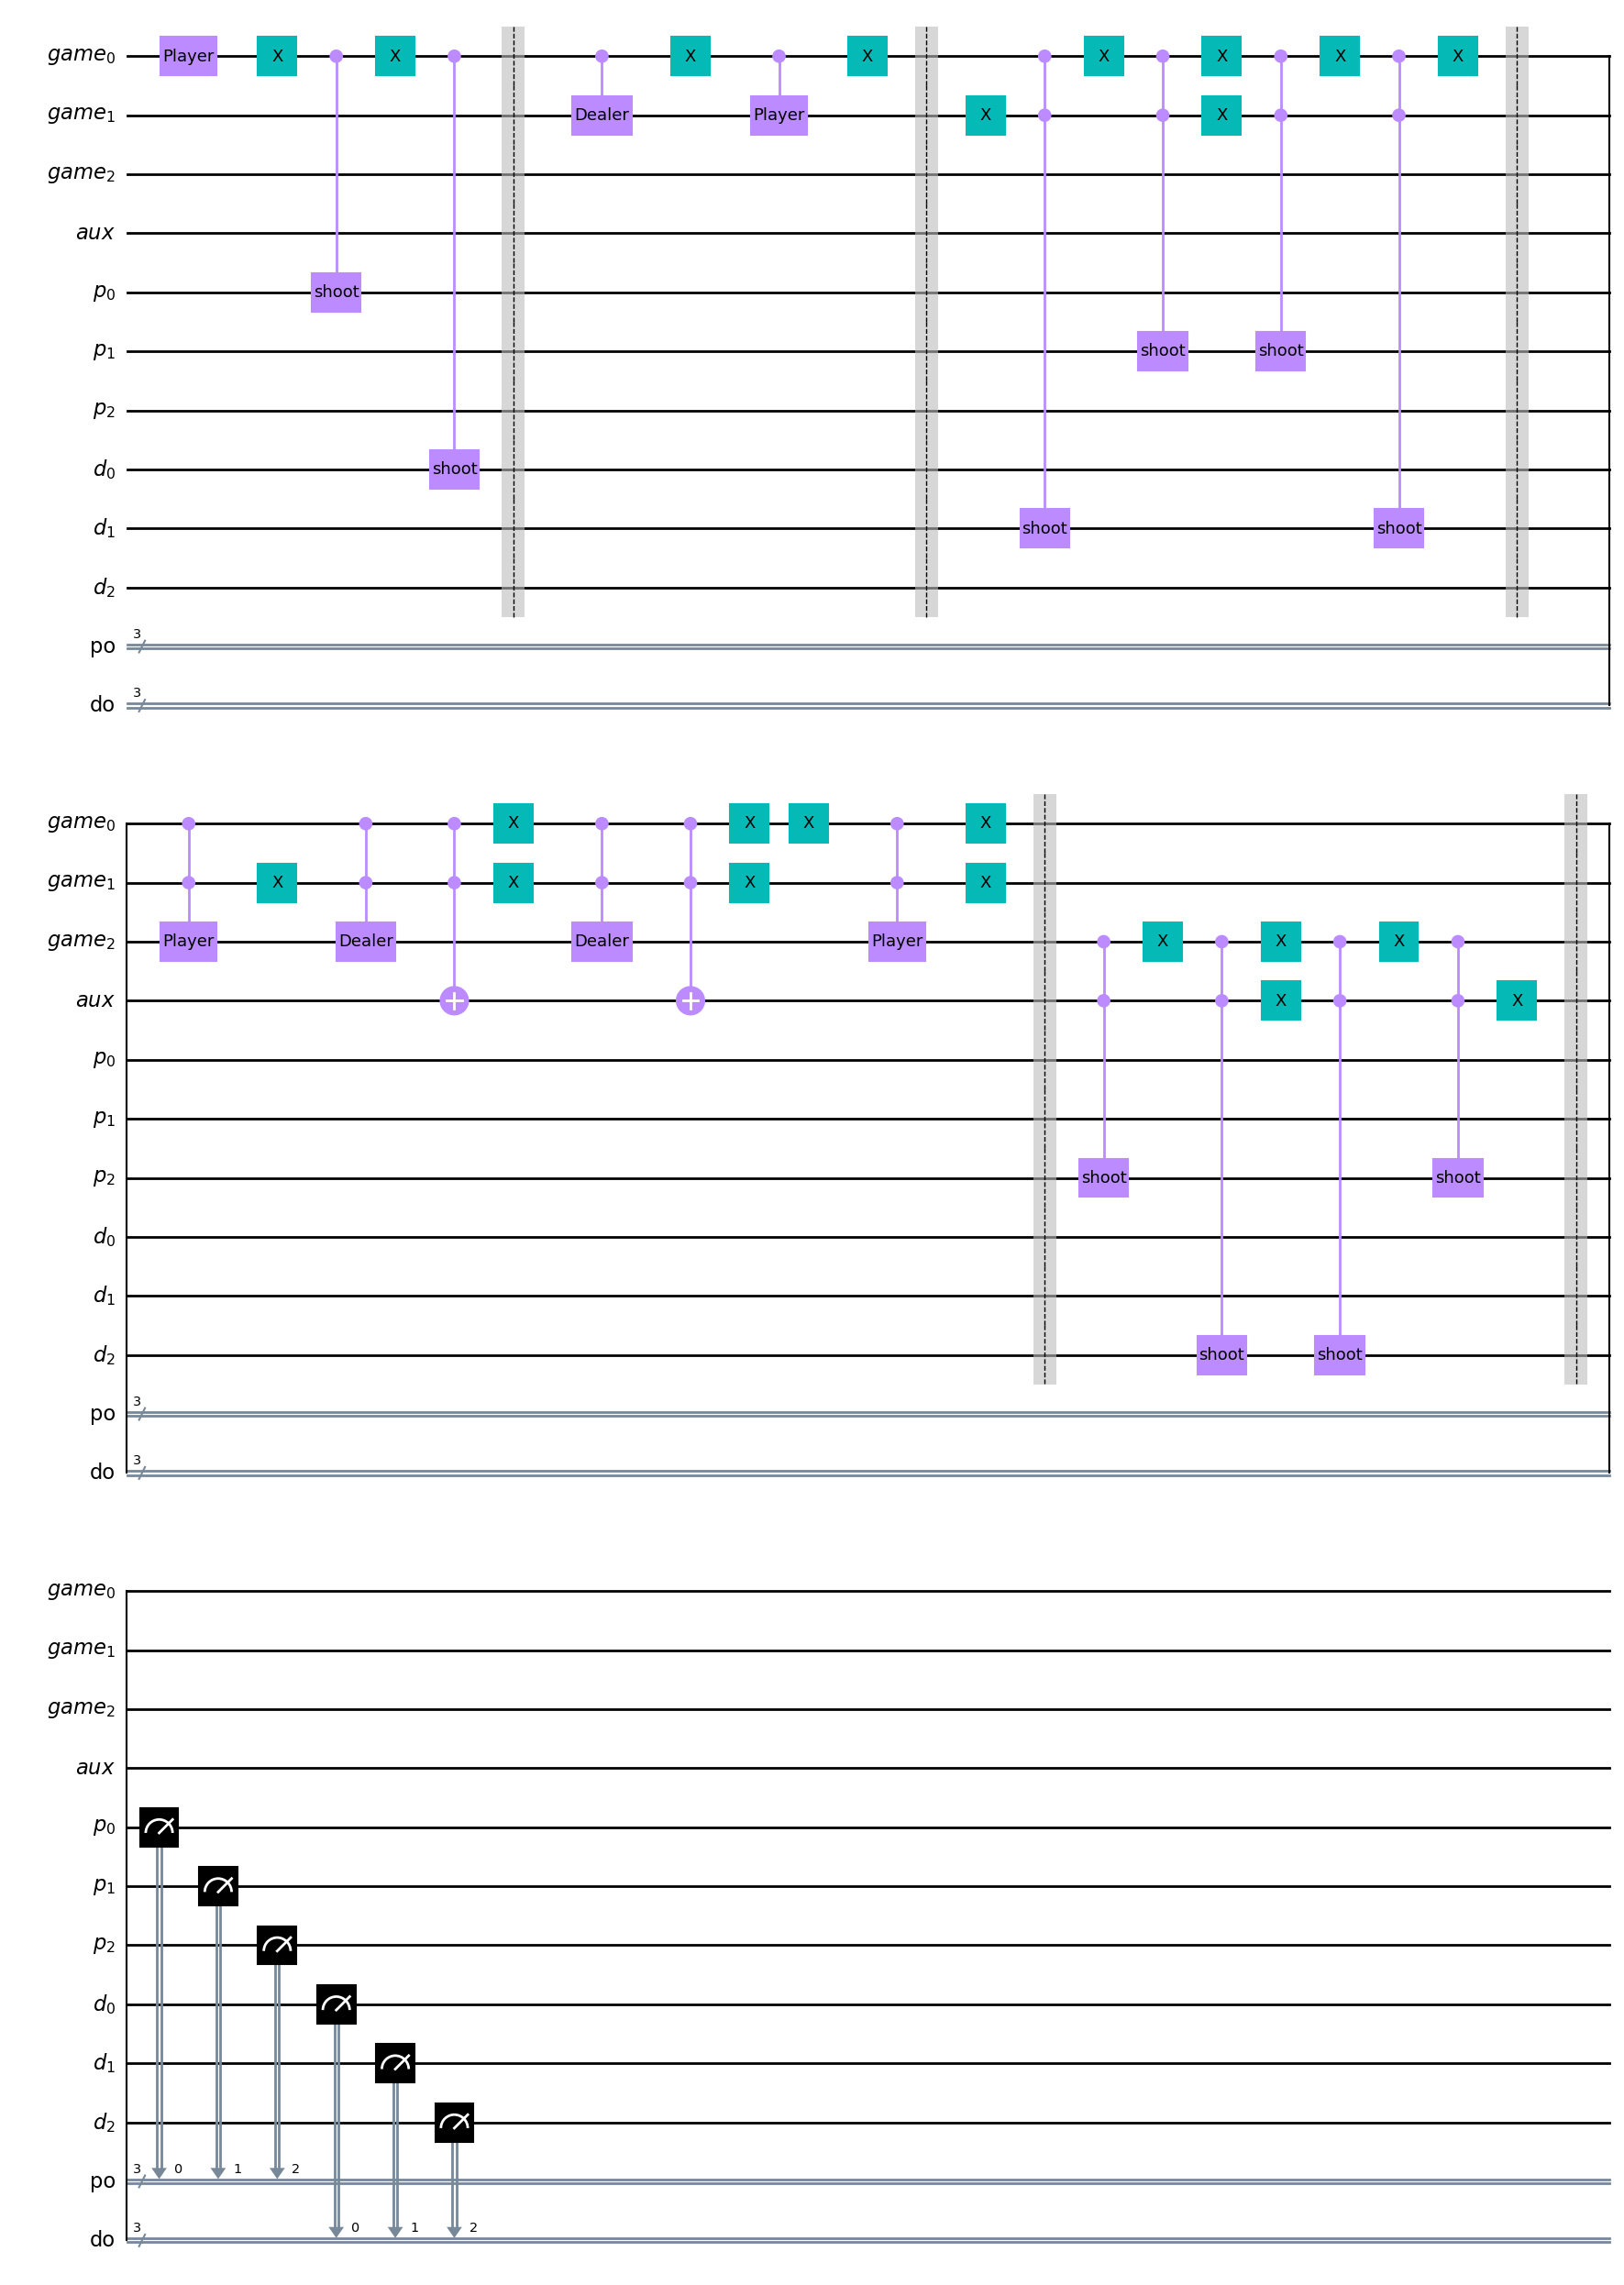

In [5]:
def buckshot_roulette(player, dealer, gun):
    player_gate = player.to_gate()
    player_controlled_gate = player.to_gate().control(1)
    player_two_controlled_gate = player.to_gate().control(2)
    
    dealer_controlled_gate = dealer.to_gate().control(1)
    dealer_two_controlled_gate = dealer.to_gate().control(2)
    
    gun_controlled_gate = gun.to_gate().control(1)
    gun_two_controlled_gate = gun.to_gate().control(2)
    
    player_life  = QuantumRegister(3, name="p") 
    dealer_life  = QuantumRegister(3, name="d")
    game = QuantumRegister(3, name="game")
    player_life_out = ClassicalRegister(3, name="po")
    dealer_life_out = ClassicalRegister(3, name="do")
    aux = AncillaRegister(1, name="aux")
    
    qc = QuantumCircuit(game, aux, player_life, dealer_life, player_life_out, dealer_life_out)
    
    qc.append(player.copy(), [game[0]])
    qc.x(game[0])
    qc.append(gun_controlled_gate.copy(), [game[0], player_life[0]])
    qc.x(game[0])
    qc.append(gun_controlled_gate.copy(), [game[0], dealer_life[0]])
    
    #next_player
    # 0 = player, 1 = dealer
    
    qc.barrier()
    
    qc.append(dealer_controlled_gate, [game[0], game[1]])
    qc.x(game[0])
    qc.append(player_controlled_gate, [game[0], game[1]])
    qc.x(game[0])
    qc.barrier()
    
    qc.x(game[1])
    qc.append(gun_two_controlled_gate, [game[0], game[1], dealer_life[1]])
    qc.x(game[0])
    qc.append(gun_two_controlled_gate, [game[0], game[1], player_life[1]])
    qc.x(game[0])
    
    qc.x(game[1])
    qc.append(gun_two_controlled_gate, [game[0], game[1], player_life[1]])
    qc.x(game[0])
    qc.append(gun_two_controlled_gate, [game[0], game[1], dealer_life[1]])
    qc.x(game[0])
    
    qc.barrier()
    
    qc.append(player_two_controlled_gate, [game[0], game[1], game[2]])
    
    qc.x(game[1])
    qc.append(dealer_two_controlled_gate, [game[0], game[1], game[2]])
    qc.ccx(game[0], game[1], aux)
    qc.x(game[1])
    
    qc.x(game[0])
    qc.append(dealer_two_controlled_gate, [game[0], game[1], game[2]])
    qc.ccx(game[0], game[1], aux)
    qc.x(game[0])
    
    qc.x([game[0], game[1]])
    qc.append(player_two_controlled_gate, [game[0], game[1], game[2]])
    qc.x([game[0], game[1]])
    qc.barrier()
    
    qc.append(gun_two_controlled_gate, [aux, game[2], player_life[2]])
    qc.x(game[2])
    qc.append(gun_two_controlled_gate, [aux, game[2], dealer_life[2]])
    qc.x(game[2])
    qc.x(aux)
    qc.append(gun_two_controlled_gate, [aux, game[2], dealer_life[2]])
    qc.x(game[2])
    qc.append(gun_two_controlled_gate, [aux, game[2], player_life[2]])
    qc.x(aux)
    
    
    qc.barrier()
    qc.measure(player_life, player_life_out)
    qc.measure(dealer_life, dealer_life_out)
    
    return qc


qc = buckshot_roulette(player, dealer, gun)
qc.draw('mpl', style="clifford", filename=get_image_path("quantum_buckshot_roulette.png"))

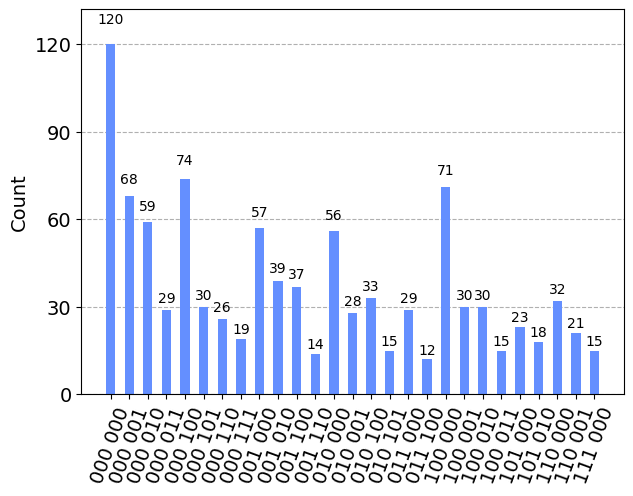

In [6]:
sim = AerSimulator()
transpiled_qc = transpile(buckshot_roulette(player, dealer, gun), sim)
result = sim.run(transpiled_qc, shots=1000).result().get_counts()
plot_histogram(result)

In [59]:
def parse_results(results):
    wins = {'dealer':0, 'player':0}
    for d,v in results.items():
        #v_bin = f"{v:06b}"
        bin_dealer, bin_player = d[:3], d[4:]

        #first_match
        first_dealer, first_player = bin_dealer[-1], bin_player[-1]
        #second_match
        second_dealer, second_player = bin_dealer[-2], bin_player[-2]
        #third_match
        third_dealer, third_player = bin_dealer[-3], bin_player[-3]

        if(first_dealer != first_player):
            winner = "dealer" if first_dealer == '0' else "player"
            wins[winner]+=v
            continue
            
        if(second_dealer != second_player):
            winner = "dealer" if second_dealer == '0' else "player"
            wins[winner]+=v
            continue
            
        if(third_dealer != third_player):
            winner = "dealer" if third_dealer == '0' else "player"
            wins[winner]+= v
            continue
        
    return wins    
parse_results(result)

{'dealer': 166, 'player': 708}

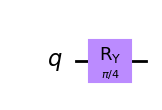

In [8]:
player_2 = QuantumCircuit(1)
player_2.ry(np.pi/4, 0)
player_2.draw('mpl', style='clifford')

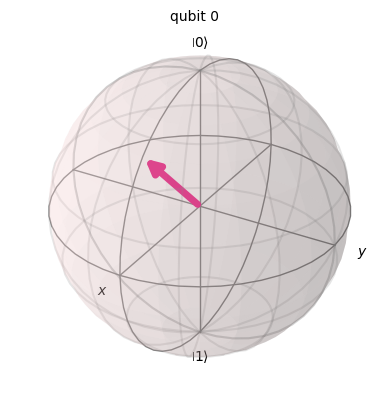

In [218]:
plot_bloch_multivector(player_2)

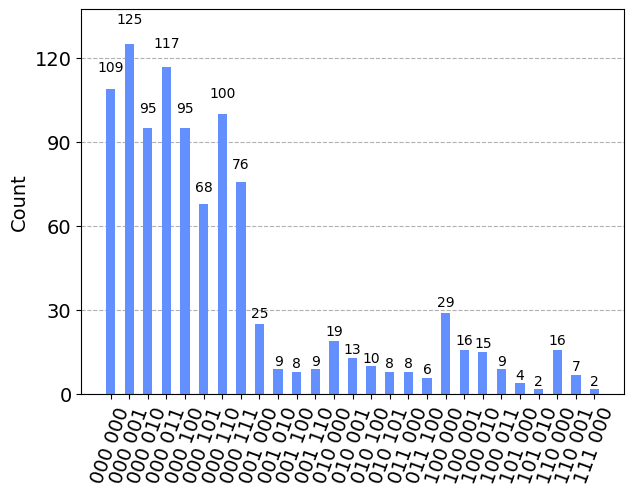

In [9]:
sim = AerSimulator()
transpiled_qc = transpile(buckshot_roulette(player_2, dealer, gun), sim)
result = sim.run(transpiled_qc, shots=1000).result().get_counts()
plot_histogram(result)

In [220]:
parse_results(result)

{'dealer': 145, 'player': 731}

In [77]:
np.linspace(0, 2*np.pi, num=1)

array([0.])

In [205]:
def obj(x, sim, shots):
    player_var = QuantumCircuit(1)
    theta = Parameter('theta')
    phi = Parameter('phi')
    lam = Parameter('lambda')
    
    player_var.u(theta, phi, lam, 0)

    player_var = player_var.assign_parameters({theta:x[0], phi:x[1], lam:x[2]})
    qc = buckshot_roulette(player_var, dealer, gun)
    
    transpiled_qc = transpile(qc, sim)
    result = sim.run(transpiled_qc, shots=shots).result().get_counts()
    
    parsed_result = parse_results(result)
    print(parsed_result, x)
    return parsed_result['dealer']

minimized = minimize(
    x0=[0, 0, 0],
    bounds=[(0, np.pi), (0, 2*np.pi), (0,None)],
    fun=obj, 
    args=(AerSimulator(), 1000),
    method="COBYLA")
minimized

{'dealer': 875, 'player': 0} [0. 0. 0.]
{'dealer': 650, 'player': 216} [1. 0. 0.]
{'dealer': 673, 'player': 203} [1. 1. 0.]
{'dealer': 624, 'player': 235} [1. 0. 1.]
{'dealer': 291, 'player': 579} [ 1.9883071  -0.10102695  1.11420438]
{'dealer': 161, 'player': 720} [ 2.98287187 -0.17001391  1.19218964]
{'dealer': 155, 'player': 720} [ 3.43237616 -0.26249681  2.08066744]
{'dealer': 171, 'player': 702} [ 3.400657   -0.7602067   2.04490768]
{'dealer': 366, 'player': 520} [ 4.33384153 -0.08069219  1.6878478 ]
{'dealer': 179, 'player': 717} [ 3.00201604 -0.18111083  2.32184474]
{'dealer': 172, 'player': 701} [ 3.64136491 -0.14231214  2.01449081]
{'dealer': 192, 'player': 683} [ 3.47574245 -0.27364564  2.19737249]
{'dealer': 158, 'player': 716} [ 3.27876561 -0.21334974  1.88964816]
{'dealer': 142, 'player': 711} [ 3.35253904 -0.22873143  2.17072816]
{'dealer': 161, 'player': 720} [ 3.27028113 -0.20497483  2.26180099]
{'dealer': 159, 'player': 718} [ 3.33066611 -0.28722393  2.17326811]
{'deal

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 185.0
       x: [ 3.365e+00 -1.075e-01  2.198e+00]
    nfev: 41
   maxcv: 0.0

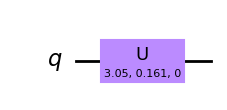

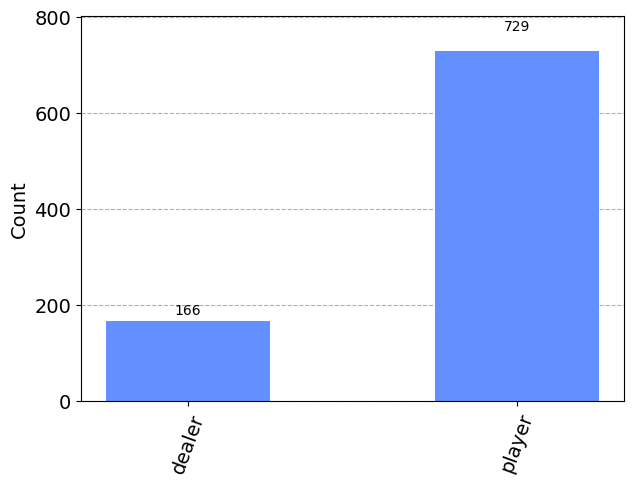

In [203]:
player_optimal = QuantumCircuit(1)
player_optimal.u(minimized.x[0], minimized.x[1],0, 0)
display(player_optimal.draw('mpl', style='clifford'))
qc = buckshot_roulette(player_optimal, dealer, gun)
transpiled_qc = transpile(qc, sim)
result = sim.run(transpiled_qc, shots=shots).result().get_counts()
plot_histogram(parse_results(result))

In [206]:
def obj(x, sim, shots):
    player_var = QuantumCircuit(1)
    theta = Parameter('theta')
    player_var.ry(theta, 0)
    player_var = player_var.assign_parameters({theta:x})
    qc = buckshot_roulette(player_var, dealer, gun)
    
    transpiled_qc = transpile(qc, sim)
    result = sim.run(transpiled_qc, shots=shots).result().get_counts()
    
    parsed_result = parse_results(result)
    print(parsed_result, x)
    return parsed_result['dealer']

def custom_minimizer(fun, args, **kwargs):
    bounds = kwargs['bounds']
    best_x = 0
    best_y = 100000
    rounds = 0
    
    for v in np.arange(bounds[0], bounds[1], 0.01):
        y = fun(v,args[0], args[1])
        if(y < best_y):
            best_y = y
            best_x = v
    
        rounds+=1
    print(best_x, best_y)

    return OptimizeResult(fun=best_y, x=best_x, nit=0, nfev=rounds, success=True)

minimized = minimize_scalar(
    fun=obj, 
    bounds=(0, 2*np.pi),
    args=(AerSimulator(), 1000),
    method=custom_minimizer)

minimized

{'dealer': 884, 'player': 0} 0.0
{'dealer': 880, 'player': 0} 0.01
{'dealer': 891, 'player': 0} 0.02
{'dealer': 880, 'player': 0} 0.03
{'dealer': 866, 'player': 0} 0.04
{'dealer': 864, 'player': 0} 0.05
{'dealer': 855, 'player': 1} 0.06
{'dealer': 872, 'player': 2} 0.07
{'dealer': 879, 'player': 2} 0.08
{'dealer': 895, 'player': 2} 0.09
{'dealer': 877, 'player': 4} 0.1
{'dealer': 873, 'player': 9} 0.11
{'dealer': 868, 'player': 5} 0.12
{'dealer': 864, 'player': 5} 0.13
{'dealer': 862, 'player': 6} 0.14
{'dealer': 874, 'player': 5} 0.15
{'dealer': 865, 'player': 4} 0.16
{'dealer': 861, 'player': 12} 0.17
{'dealer': 850, 'player': 6} 0.18
{'dealer': 849, 'player': 6} 0.19
{'dealer': 868, 'player': 8} 0.2
{'dealer': 869, 'player': 15} 0.21
{'dealer': 858, 'player': 18} 0.22
{'dealer': 861, 'player': 9} 0.23
{'dealer': 862, 'player': 12} 0.24
{'dealer': 850, 'player': 13} 0.25
{'dealer': 851, 'player': 23} 0.26
{'dealer': 859, 'player': 21} 0.27
{'dealer': 858, 'player': 26} 0.28
{'dealer'

 success: True
     fun: 127
       x: 3.15
     nit: 0
    nfev: 629

In [218]:
def obj(x, sim, shots):
    player_var = QuantumCircuit(1)
    theta = Parameter('theta')
    phi = Parameter('phi')
    
    player_var.u(theta, phi, 0, 0)

    player_var = player_var.assign_parameters({theta:x[0], phi:x[1]})
    qc = buckshot_roulette(player_var, dealer, gun)
    
    transpiled_qc = transpile(qc, sim)
    result = sim.run(transpiled_qc, shots=shots).result().get_counts()
    
    parsed_result = parse_results(result)
    print(parsed_result, x)
    return parsed_result['dealer']

def custom_minimizer(fun, x0, args, **kwargs):
    bounds = kwargs['bounds']
    best_x = []
    best_y = 100000
    rounds = 0

    for i in np.arange(bounds[0][0], bounds[0][1], 0.1):
        for j in np.arange(bounds[1][0], bounds[1][1], 0.1):
            y = fun([i, j], args[0], args[1])
            if(y < best_y):
                best_y = y
                best_x = [i, j]
            
            rounds+=1
                
    print(best_x, best_y)

    return OptimizeResult(fun=best_y, x=best_x, nit=0, nfev=rounds, success=True)

minimized = minimize(
    x0=[0, 0],
    bounds=[(np.pi/4, np.pi), (np.pi/4, 2*np.pi)],
    fun=obj, 
    args=(AerSimulator(), 1000),
    method=custom_minimizer)
minimized

{'dealer': 706, 'player': 153} [0.7853981633974483, 0.7853981633974483]
{'dealer': 715, 'player': 151} [0.7853981633974483, 0.8853981633974483]
{'dealer': 736, 'player': 142} [0.7853981633974483, 0.9853981633974482]
{'dealer': 713, 'player': 154} [0.7853981633974483, 1.085398163397448]
{'dealer': 734, 'player': 159} [0.7853981633974483, 1.1853981633974482]
{'dealer': 727, 'player': 147} [0.7853981633974483, 1.2853981633974483]
{'dealer': 720, 'player': 157} [0.7853981633974483, 1.3853981633974481]
{'dealer': 737, 'player': 146} [0.7853981633974483, 1.485398163397448]
{'dealer': 733, 'player': 145} [0.7853981633974483, 1.585398163397448]
{'dealer': 721, 'player': 150} [0.7853981633974483, 1.6853981633974482]
{'dealer': 731, 'player': 144} [0.7853981633974483, 1.785398163397448]
{'dealer': 728, 'player': 162} [0.7853981633974483, 1.885398163397448]
{'dealer': 722, 'player': 146} [0.7853981633974483, 1.985398163397448]
{'dealer': 723, 'player': 148} [0.7853981633974483, 2.085398163397448]

 success: True
     fun: 133
       x: [2.9853981633974476, 4.385398163397447]
     nit: 0
    nfev: 1320

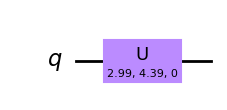

In [219]:
player_optimal = QuantumCircuit(1)
player_optimal.u(minimized.x[0], minimized.x[1],0, 0)
player_optimal.draw('mpl', style='clifford')

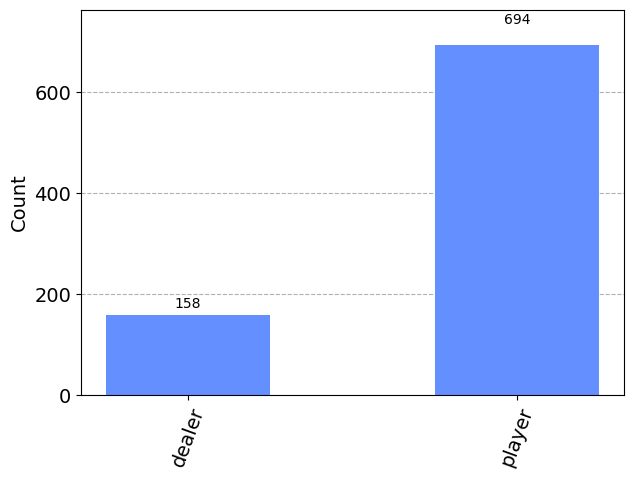

In [220]:
qc = buckshot_roulette(player_optimal, dealer, gun)
transpiled_qc = transpile(qc, sim)
result = sim.run(transpiled_qc, shots=shots).result().get_counts()
plot_histogram(parse_results(result))

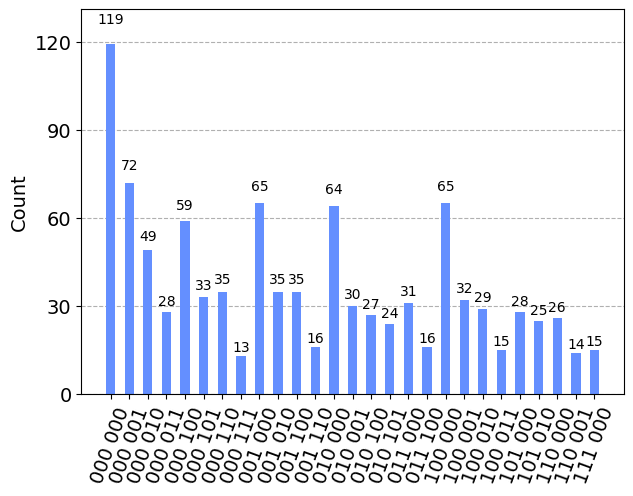

In [66]:
plot_histogram(result)